# Face detection Using HOG features
 In this notebook you will train a face detector using HOG features

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import data, color, feature
import skimage.data

## Visualize the HOG features

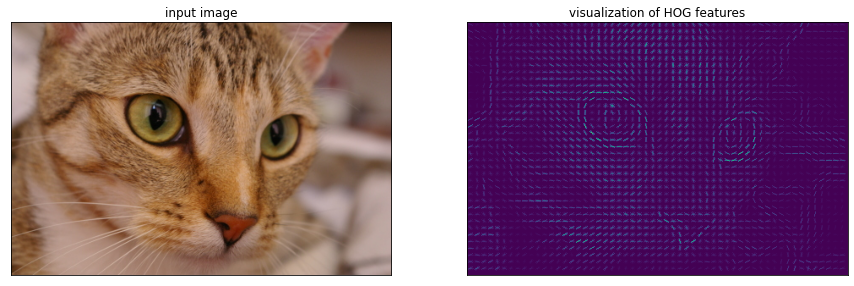

In [2]:
from skimage import data, color, feature
import skimage.data

image = data.chelsea()
hog_vec, hog_vis = feature.hog(image, visualize=True)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title('input image')
plt.subplot(1,2,2)
plt.imshow(hog_vis)
plt.xticks([]), plt.yticks([])
plt.title('visualization of HOG features');

## Load the face dataset
Here we load a real dataset provided by [sklearn.datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) which contain faces of 5749 peoples with 13233 total samples and of dimension (62,47) 

Shape of the dataset is:  (13233, 62, 47)


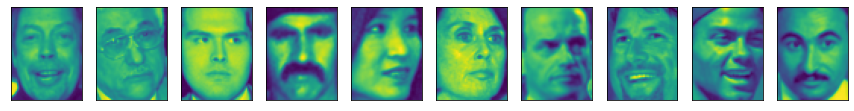

In [8]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
print("Shape of the dataset is: ",positive_patches.shape)
plt.figure(figsize=(15,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(positive_patches[i,:,:])
    plt.xticks([]), plt.yticks([])

## Load the  negative image dataset
Here we load so many 10 images from skimage.data

In [9]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

<ipython-input-9-4ff79985fbcb>:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


## Extract patches for negative images

In [10]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

## Display the negative patches

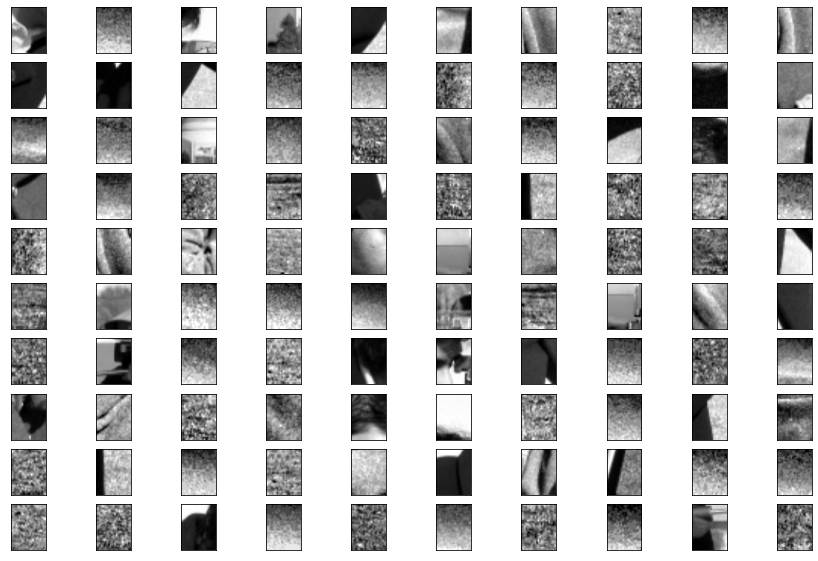

In [11]:
plt.figure(figsize=(15,10))
for j in range(10):
    for i in range(10):
        plt.subplot(10,10,(j)*10+i+1)
        #print((j+1)*10+i+1)
        plt.imshow(negative_patches[j*10+i,:,:], cmap='gray')
        plt.xticks([]), plt.yticks([])

## Create the training feature set and labels

In [12]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

## Define the Classifer
- Here we use linear SVM classifier
- Use grid search to get best coefficient value for the given data
- Use the best estimator as the model


In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
model = grid.best_estimator_

C:\Users\Admin.LAPTOP-ODP68EPU\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Admin.LAPTOP-ODP68EPU\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Admin.LAPTOP-ODP68EPU\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Admin.LAPTOP-ODP68EPU\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Admin.LAPTOP-ODP68EPU\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: Con

## Load the test image

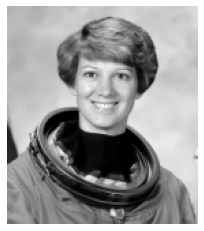

In [14]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

## Extract the patches from the image using a sliding window
- Extract patches from for the patch_size we learned for
- Extract the HOG features for each patch size

In [15]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2):
    Ni, Nj =  patch_size
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

## Classify the patches

In [16]:
labels = model.predict(patches_hog)
np.where(labels==1)

(array([416, 452, 453, 454, 455, 490, 491, 492, 493, 494, 495, 529, 530,
        531, 532, 533, 534, 568, 569, 570, 571, 572, 573, 607, 608, 609,
        610, 611, 612, 646, 647, 648, 649, 650, 686, 687, 688, 689, 726,
        727, 803, 804, 805, 842, 843, 844, 882, 921], dtype=int64),)

## Display the result

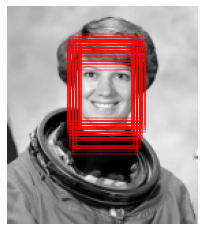

In [17]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

Get more explanation from this [link](https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html)